In [1]:
import os
from datasets import load_dataset

# Set Hugging Face token as environment variable
os.environ["HF_TOKEN"] = ""

# Load the datasets
reasoning_prefixes_suffixes = load_dataset("avrecum/reasoning_prefixes_suffixes", use_auth_token=os.environ["HF_TOKEN"])
reasoning_prefixes_suffixes_no_backtracking = load_dataset("avrecum/reasoning_prefixes_suffixes_no_backtracking", use_auth_token=os.environ["HF_TOKEN"])
reasoning_prefixes_suffixes_no_backtracking_random = load_dataset("avrecum/reasoning_prefixes_suffixes_no_backtracking_random", use_auth_token=os.environ["HF_TOKEN"])

# Print dataset info to verify loading
print("Datasets loaded successfully:")
print(f"reasoning_prefixes_suffixes: {reasoning_prefixes_suffixes}")
print(f"reasoning_prefixes_suffixes_no_backtracking: {reasoning_prefixes_suffixes_no_backtracking}")
print(f"reasoning_prefixes_suffixes_no_backtracking_random: {reasoning_prefixes_suffixes_no_backtracking_random}")


/usr/local/lib/python3.10/dist-packages/datasets/load.py:2566: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2566: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(


Datasets loaded successfully:
reasoning_prefixes_suffixes: DatasetDict({
    train: Dataset({
        features: ['prefix', 'suffix', 'marker', 'source_id', 'question', 'answer'],
        num_rows: 56007
    })
})
reasoning_prefixes_suffixes_no_backtracking: DatasetDict({
    train: Dataset({
        features: ['prefix', 'suffix', 'marker', 'source_id', 'question', 'answer'],
        num_rows: 19397
    })
})
reasoning_prefixes_suffixes_no_backtracking_random: DatasetDict({
    train: Dataset({
        features: ['prefix', 'suffix', 'marker', 'source_id', 'question', 'answer'],
        num_rows: 58663
    })
})


Let's get k random samples from all three datasets.

In [2]:
import random
import numpy as np

# Set a fixed seed for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

# Number of samples to keep from each dataset
k = 1000  # You can adjust this value as needed

# Function to get k random samples from a dataset
def get_k_random_samples(dataset, k, seed=42):
    # Get the train split
    train_data = dataset['train']
    
    # Set seed for reproducibility
    random.seed(seed)
    
    # Get k random indices
    indices = random.sample(range(len(train_data)), k)
    
    # Select only those samples
    return train_data.select(indices)

# Get k random samples from each dataset
backtracking_samples = get_k_random_samples(reasoning_prefixes_suffixes, k, random_seed)
no_backtracking_samples = get_k_random_samples(reasoning_prefixes_suffixes_no_backtracking, k, random_seed)
random_samples = get_k_random_samples(reasoning_prefixes_suffixes_no_backtracking_random, k, random_seed)

# Print info about the sampled datasets
print(f"\nSampled {k} examples from each dataset:")
print(f"backtracking_samples: {len(backtracking_samples)} examples")
print(f"no_backtracking_samples: {len(no_backtracking_samples)} examples")
print(f"random_samples: {len(random_samples)} examples")



Sampled 1000 examples from each dataset:
backtracking_samples: 1000 examples
no_backtracking_samples: 1000 examples
random_samples: 1000 examples


We will now load the hooked model and collect activations from all layers. Because I'm GPU poor, we have to flush them to RAM every now and then to avoid filling up the VRAM of my GPU too much.

In [3]:
# Import necessary libraries
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformer_lens import HookedTransformer
import torch
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the model using HookedTransformer
print("Loading DeepSeek-R1-Distill-Llama-8B with HookedTransformer...")
model_name = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# First load the model with HuggingFace to pass to HookedTransformer
print("Loading model with HuggingFace first...")
hf_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,  # Use bfloat16 precision for memory efficiency
    trust_remote_code=True,
)

# Now load with HookedTransformer using the HuggingFace model
model = HookedTransformer.from_pretrained_no_processing(
    "meta-llama/Meta-Llama-3-8B",  # Use Llama-3-8B architecture as base
    hf_model=hf_model,             # Pass the actual model weights of our reasoning model
    device=device,
    dtype=torch.bfloat16,
    tokenizer=tokenizer,
)

print(f"Model loaded successfully: {model_name}")
print(f"Model has {model.cfg.n_layers} layers and {model.cfg.n_heads} attention heads")


Using device: cuda
Loading DeepSeek-R1-Distill-Llama-8B with HookedTransformer...
Loading model with HuggingFace first...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Meta-Llama-3-8B into HookedTransformer
Model loaded successfully: deepseek-ai/DeepSeek-R1-Distill-Llama-8B
Model has 32 layers and 32 attention heads


For reference, loading the model took up 17958 MiB VRAM. We should stay close to that number, otherwise we're probably keeping unnecessary stuff on the GPU.

We need to make sure we are following the chat template of the model properly, otherwise our results might be flawed.

The chat template of the `deepseek-ai/DeepSeek-R1-Distill-Llama-8B` model is as follows:

`<｜begin▁of▁sentence｜>{system_message}<｜User｜>{prompt}<｜Assistant｜><think>\n{reasoning_prefix}`

It then ends with `\n</think>{output}<｜end▁of▁sentence｜>`

In [4]:
# Tokenize the beginning of sentence token
begin_token = "<｜begin▁of▁sentence｜>"
begin_token_ids = tokenizer.encode(begin_token, add_special_tokens=False)
print(begin_token)
print(f"Token IDs: {begin_token_ids}")
print(f"Decoded back: {tokenizer.decode(begin_token_ids)}")


<｜begin▁of▁sentence｜>
Token IDs: [128000]
Decoded back: <｜begin▁of▁sentence｜>


In [5]:
def format_prompt(prompt, reasoning_prefix, system_message="You are a helpful assistant."):
    """
    Format a prompt according to the DeepSeek-R1-Distill-Llama-8B chat template.
    
    Args:
        prompt (str): The user's question or prompt
        reasoning_prefix (str): The beginning of the model's reasoning
        system_message (str, optional): System message to guide the model. Defaults to "".
        
    Returns:
        str: Formatted prompt following the chat template
    """
    formatted_prompt = f"<｜begin▁of▁sentence｜>{system_message}<｜User｜>{prompt}<｜Assistant｜><think>\n{reasoning_prefix}"
    return formatted_prompt

# Example usage
example_prompt = "What is the capital of France?"
example_reasoning = "To answer this question, I need to recall geographic facts about France."
formatted_example = format_prompt(example_prompt, example_reasoning)
print("Example formatted prompt:")
print(formatted_example)
print("\nNote: The full template would end with '\\n</think>{output}<｜end▁of▁sentence｜>' after the model generates its reasoning.")


Example formatted prompt:
<｜begin▁of▁sentence｜>You are a helpful assistant.<｜User｜>What is the capital of France?<｜Assistant｜><think>
To answer this question, I need to recall geographic facts about France.

Note: The full template would end with '\n</think>{output}<｜end▁of▁sentence｜>' after the model generates its reasoning.


In [6]:
# Tokenize the formatted example to see how it's represented as tokens
tokens = tokenizer.tokenize(formatted_example)
token_ids = tokenizer.encode(formatted_example, add_special_tokens=False)

print("Tokens:")
print(tokens)
print(f"\nToken IDs:")
print(token_ids)
print(f"\nNumber of tokens: {len(tokens)}")

# Decode back to verify correctness
decoded = tokenizer.decode(token_ids)
print(f"\nDecoded back:")
print(decoded)


Tokens:
['<｜begin▁of▁sentence｜>', 'You', 'Ġare', 'Ġa', 'Ġhelpful', 'Ġassistant', '.', '<｜User｜>', 'What', 'Ġis', 'Ġthe', 'Ġcapital', 'Ġof', 'ĠFrance', '?', '<｜Assistant｜>', '<think>', 'Ċ', 'To', 'Ġanswer', 'Ġthis', 'Ġquestion', ',', 'ĠI', 'Ġneed', 'Ġto', 'Ġrecall', 'Ġgeographic', 'Ġfacts', 'Ġabout', 'ĠFrance', '.']

Token IDs:
[128000, 2675, 527, 264, 11190, 18328, 13, 128011, 3923, 374, 279, 6864, 315, 9822, 30, 128012, 128013, 198, 1271, 4320, 420, 3488, 11, 358, 1205, 311, 19635, 46139, 13363, 922, 9822, 13]

Number of tokens: 32

Decoded back:
<｜begin▁of▁sentence｜>You are a helpful assistant.<｜User｜>What is the capital of France?<｜Assistant｜><think>
To answer this question, I need to recall geographic facts about France.


In [7]:
# Generate a completion using the model with the formatted example
with torch.no_grad():
    input_ids = tokenizer.encode(formatted_example, return_tensors="pt").to(device)
    
    # Generate with sampling parameters
    output = model.generate(
        input_ids,
        max_new_tokens=1000,
        do_sample=True,
        top_p=0.9,
        temperature=0.3,
    )
    
    # Decode the generated output
    generated_text = tokenizer.decode(output[0], skip_special_tokens=False)
    
    # Print the full generated text
    print("Generated completion:")
    print(generated_text)
    
    # Extract just the new part that was generated
    input_text_length = len(tokenizer.decode(input_ids[0], skip_special_tokens=False))
    new_text = generated_text[input_text_length:]
    print("\n=============")
    print("\nJust the newly generated part:")
    print(new_text)


  0%|          | 0/1000 [00:00<?, ?it/s]

Generated completion:
<｜begin▁of▁sentence｜><｜begin▁of▁sentence｜>You are a helpful assistant.<｜User｜>What is the capital of France?<｜Assistant｜><think>
To answer this question, I need to recall geographic facts about France. I know that France is a country located in Western Europe.

I remember that Paris is a major city in France. I've heard it referred to as the capital in various contexts.

I should verify if there are any other cities that might be considered co-capitals or if Paris is the sole capital.

Upon checking reliable sources, it's confirmed that Paris is the capital of France.

Therefore, the capital of France is Paris.
</think>

The capital of France is **Paris**.<｜end▁of▁sentence｜>


Just the newly generated part:
 I know that France is a country located in Western Europe.

I remember that Paris is a major city in France. I've heard it referred to as the capital in various contexts.

I should verify if there are any other cities that might be considered co-capitals or if

Alright, looking good! Now let's write a loop to get the top logits for each of our 3 datasets, and then plot them. This should show very different distributions for the backtracking tokens and both of the non-backtracking-token datasets.

Processing backtracking dataset...
Processed 0/100 samples
Processed 10/100 samples
Processed 20/100 samples
Processed 30/100 samples
Processed 40/100 samples
Processed 50/100 samples
Processed 60/100 samples
Processed 70/100 samples
Processed 80/100 samples
Processed 90/100 samples


Token indices sequence length is longer than the specified maximum sequence length for this model (19927 > 16384). Running this sequence through the model will result in indexing errors



Top 20 tokens for backtracking dataset:
1. Token: ' Wait', ID: 14144, Avg Probability: 0.1395, Occurrences: 94
2. Token: ' Hmm', ID: 89290, Avg Probability: 0.1078, Occurrences: 91
3. Token: ' But', ID: 2030, Avg Probability: 0.2172, Occurrences: 89
4. Token: ' So', ID: 2100, Avg Probability: 0.1942, Occurrences: 82
5. Token: ' However', ID: 4452, Avg Probability: 0.0450, Occurrences: 68
6. Token: ' The', ID: 578, Avg Probability: 0.0414, Occurrences: 67
7. Token: ' Let', ID: 6914, Avg Probability: 0.0593, Occurrences: 64
8. Token: ' Since', ID: 8876, Avg Probability: 0.0242, Occurrences: 63
9. Token: ' If', ID: 1442, Avg Probability: 0.0362, Occurrences: 56
10. Token: ' 

', ID: 4815, Avg Probability: 0.0578, Occurrences: 55
11. Token: ' That', ID: 3011, Avg Probability: 0.0327, Occurrences: 55
12. Token: ' Maybe', ID: 10926, Avg Probability: 0.0355, Occurrences: 52
13. Token: ' Therefore', ID: 15636, Avg Probability: 0.0620, Occurrences: 51
14. Token: ' Or', ID: 2582, Avg Probabilit

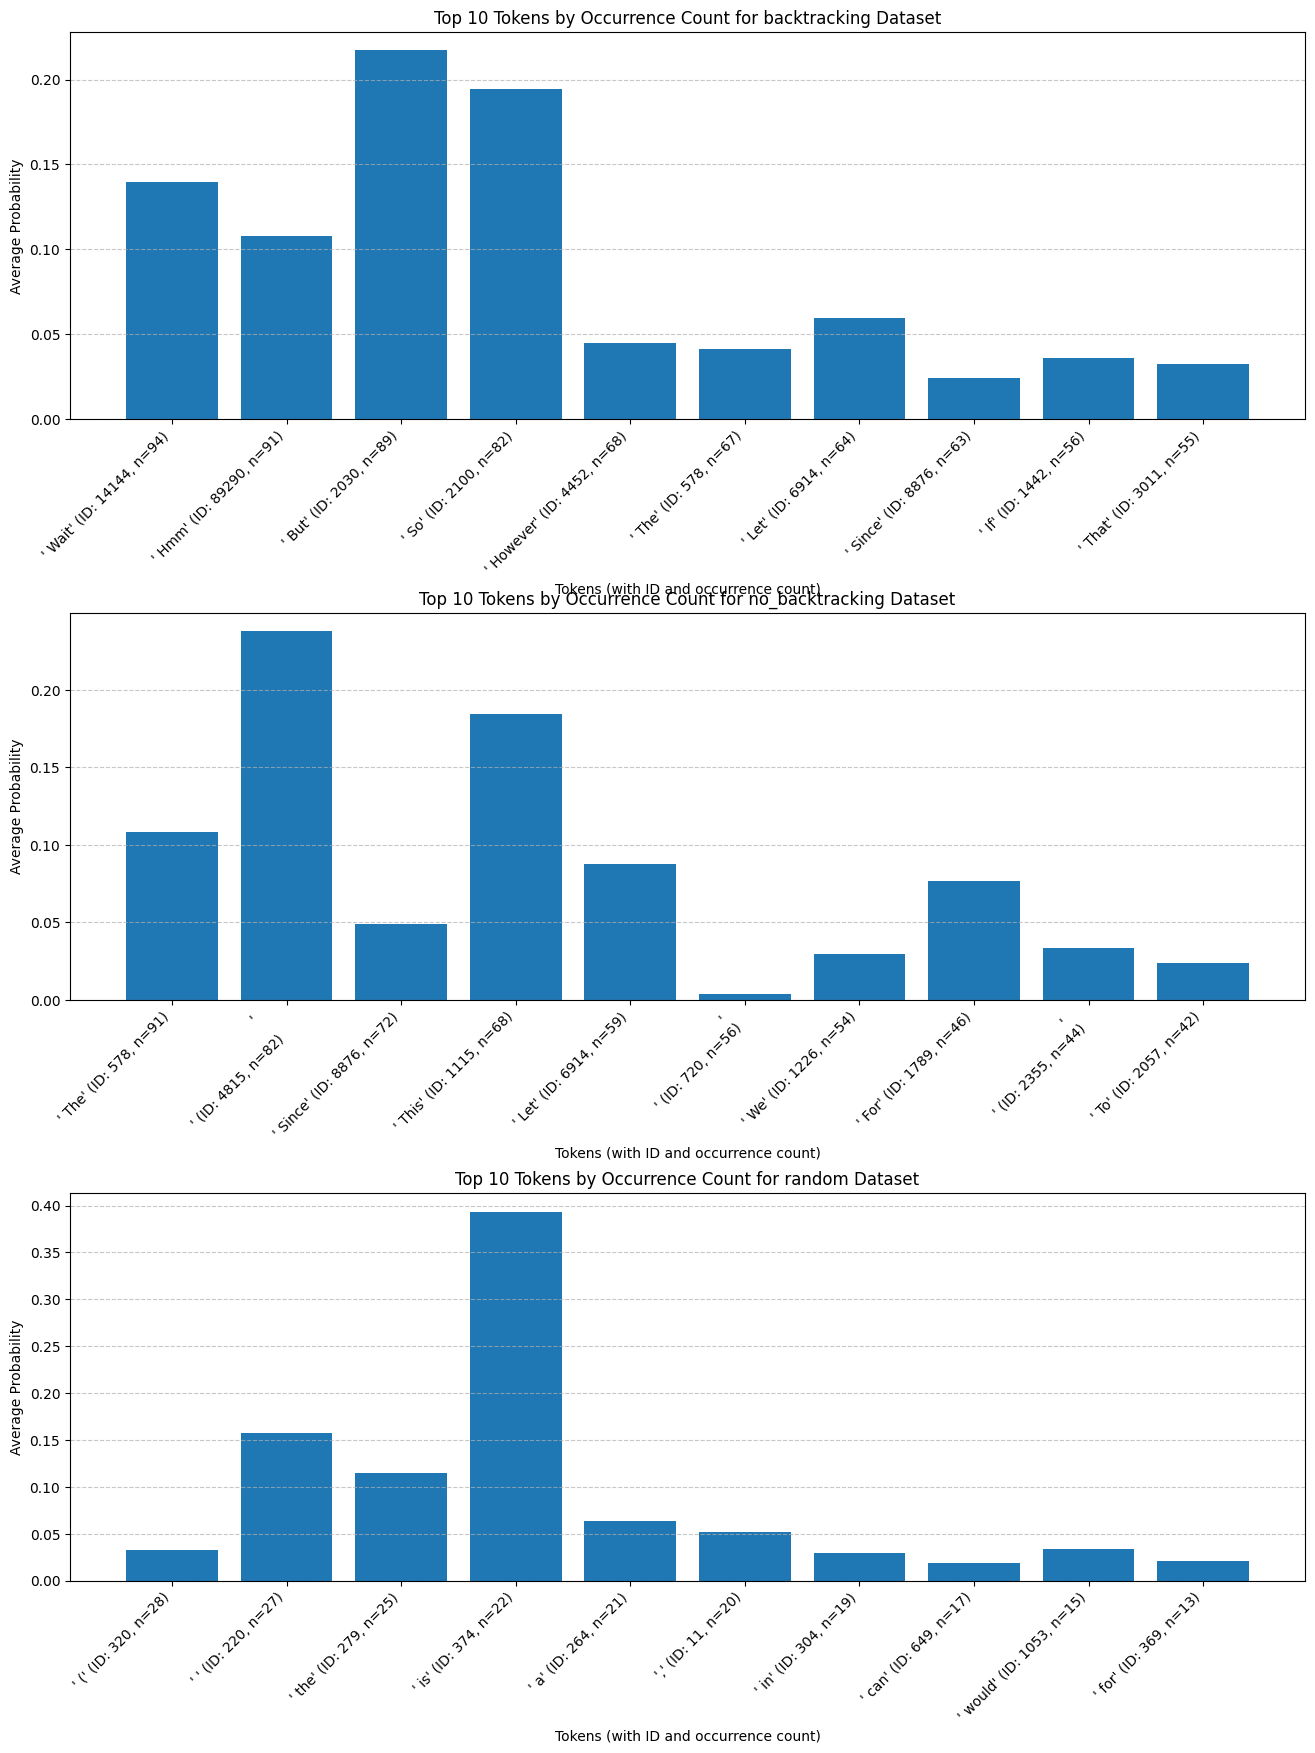

In [8]:
# Define the datasets we want to analyze
datasets = {
    "backtracking": backtracking_samples,
    "no_backtracking": no_backtracking_samples,
    "random": random_samples
}

# Function to get top logits for a dataset
def get_top_logits_for_dataset(dataset, num_samples=1000, top_k=20, batch_size=1):
    all_top_tokens = {}
    
    # Process in smaller batches to avoid OOM errors
    for i in range(0, min(num_samples, len(dataset)), batch_size):
        batch_end = min(i + batch_size, min(num_samples, len(dataset)))
        
        for j in range(i, batch_end):
            # Get the question and prefix from the dataset
            question = dataset[j]["question"]
            prefix = dataset[j]["prefix"]
            
            # Format the prompt
            formatted_prompt = format_prompt(question, prefix)
            
            # Tokenize the input
            input_ids = tokenizer.encode(formatted_prompt, return_tensors="pt").to(device)
            
            try:
                # Run a forward pass through the model
                with torch.no_grad():
                    # Clear CUDA cache before running to free up memory
                    torch.cuda.empty_cache()
                    
                    # Get only the last token's logits to save memory
                    outputs = model(input_ids[:, -512:] if input_ids.size(1) > 512 else input_ids)
                    
                # Get the logits for the last token
                logits = outputs[0, -1, :]
                
                # Convert logits to probabilities
                probs = torch.softmax(logits, dim=0)
                
                # Get the top k token ids and their probabilities
                top_probs, top_indices = torch.topk(probs, top_k)
                
                # Convert to CPU and handle BFloat16 issue by converting to float32 first
                top_indices = top_indices.cpu().numpy()
                top_probs = top_probs.float().cpu().numpy()  # Convert BFloat16 to float32 before numpy conversion
                
                # Decode the tokens and update the dictionary
                for token_id, prob in zip(top_indices, top_probs):
                    token = tokenizer.decode([token_id])
                    if token in all_top_tokens:
                        all_top_tokens[token]["count"] += 1
                        all_top_tokens[token]["total_prob"] += prob
                        all_top_tokens[token]["token_id"] = int(token_id)  # Store the token ID
                    else:
                        all_top_tokens[token] = {
                            "count": 1, 
                            "total_prob": prob, 
                            "token_id": int(token_id)  # Store the token ID
                        }
                        
            except RuntimeError as e:
                if "CUDA out of memory" in str(e):
                    print(f"CUDA OOM error on sample {j}, skipping...")
                    # Force garbage collection
                    import gc
                    gc.collect()
                    torch.cuda.empty_cache()
                else:
                    raise e
            
            # Print progress
            if j % 10 == 0:
                print(f"Processed {j}/{min(num_samples, len(dataset))} samples")
    
    # Calculate average probability for each token
    for token in all_top_tokens:
        all_top_tokens[token]["avg_prob"] = all_top_tokens[token]["total_prob"] / all_top_tokens[token]["count"]
    
    # Sort by count (number of occurrences)
    sorted_tokens = sorted(all_top_tokens.items(), key=lambda x: x[1]["count"], reverse=True)
    
    return sorted_tokens

# Collect top logits for each dataset
results = {}
for dataset_name, dataset in datasets.items():
    print(f"Processing {dataset_name} dataset...")
    results[dataset_name] = get_top_logits_for_dataset(dataset, num_samples=100)  # Reduced sample size
    
    # Print the top tokens and their average probabilities
    print(f"\nTop 20 tokens for {dataset_name} dataset:")
    for i, (token, stats) in enumerate(results[dataset_name][:20], 1):
        print(f"{i}. Token: '{token}', ID: {stats['token_id']}, Avg Probability: {stats['avg_prob']:.4f}, Occurrences: {stats['count']}")
    print("\n" + "="*50 + "\n")

# Create a DataFrame for easier visualization
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for plotting
plot_data = []
for dataset_name, tokens_data in results.items():
    for i, (token, stats) in enumerate(tokens_data):
        plot_data.append({
            "dataset": dataset_name,
            "token": token,
            "token_id": stats["token_id"],
            "avg_prob": stats["avg_prob"],
            "count": stats["count"]
        })

df = pd.DataFrame(plot_data)

# Create 3 separate plots, one for each dataset
fig, axes = plt.subplots(3, 1, figsize=(15, 18))
# Add more space between subplots
fig.tight_layout(pad=8.0)  # Increased padding between subplots
fig.subplots_adjust(hspace=0.5)  # Add vertical space between subplots

for i, dataset_name in enumerate(datasets.keys()):
    dataset_df = df[df["dataset"] == dataset_name]
    # Sort by count and take top 10
    dataset_df = dataset_df.sort_values(by="count", ascending=False).head(10)
    
    # Plot
    axes[i].bar(range(len(dataset_df)), dataset_df["avg_prob"])
    
    # Set x-ticks with token labels, IDs and counts
    token_labels = [f"'{token}' (ID: {token_id}, n={count})" for token, token_id, count in 
                   zip(dataset_df["token"], dataset_df["token_id"], dataset_df["count"])]
    axes[i].set_xticks(range(len(dataset_df)))
    axes[i].set_xticklabels(token_labels, rotation=45, ha='right')
    
    # Set labels and title
    axes[i].set_xlabel("Tokens (with ID and occurrence count)")
    axes[i].set_ylabel("Average Probability")
    axes[i].set_title(f"Top 10 Tokens by Occurrence Count for {dataset_name} Dataset")
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [9]:
# Print all top tokens and their average probabilities ordered by occurrences
print("Top tokens by occurrence count across all datasets:")
print("-" * 80)

for dataset_name in results.keys():
    print(f"\n{dataset_name} Dataset:")
    print("-" * 40)
    
    # Get tokens data for this dataset
    tokens_data = results[dataset_name]
    
    # Sort by count (descending)
    sorted_tokens = sorted(tokens_data, key=lambda x: x[1]["count"], reverse=True)
    
    # Print header
    print(f"{'Token':<15} {'Token ID':<10} {'Count':<10} {'Avg Probability':<15}")
    print("-" * 60)
    
    # Print each token's data
    for token, stats in sorted_tokens:
        token_display = repr(token)[:15]  # Use repr to show special characters and limit length
        print(f"{token_display:<15} {stats['token_id']:<10} {stats['count']:<10} {stats['avg_prob']:.6f}")


Top tokens by occurrence count across all datasets:
--------------------------------------------------------------------------------

backtracking Dataset:
----------------------------------------
Token           Token ID   Count      Avg Probability
------------------------------------------------------------
' Wait'         14144      94         0.139484
' Hmm'          89290      91         0.107834
' But'          2030       89         0.217204
' So'           2100       82         0.194209
' However'      4452       68         0.045042
' The'          578        67         0.041351
' Let'          6914       64         0.059306
' Since'        8876       63         0.024162
' If'           1442       56         0.036233
' \n\n'         4815       55         0.057762
' That'         3011       55         0.032662
' Maybe'        10926      52         0.035483
' Therefore'    15636      51         0.061990
' Or'           2582       47         0.017794
' Alternatively 39578      44 

/tmp/ipykernel_1778/972635698.py:61: UserWarning: Glyph 24418 (\N{CJK UNIFIED IDEOGRAPH-5F62}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1778/972635698.py:61: UserWarning: Glyph 24335 (\N{CJK UNIFIED IDEOGRAPH-5F0F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1500x1500 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24418 (\N{CJK UNIFIED IDEOGRAPH-5F62}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24335 (\N{CJK UNIFIED IDEOGRAPH-5F0F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


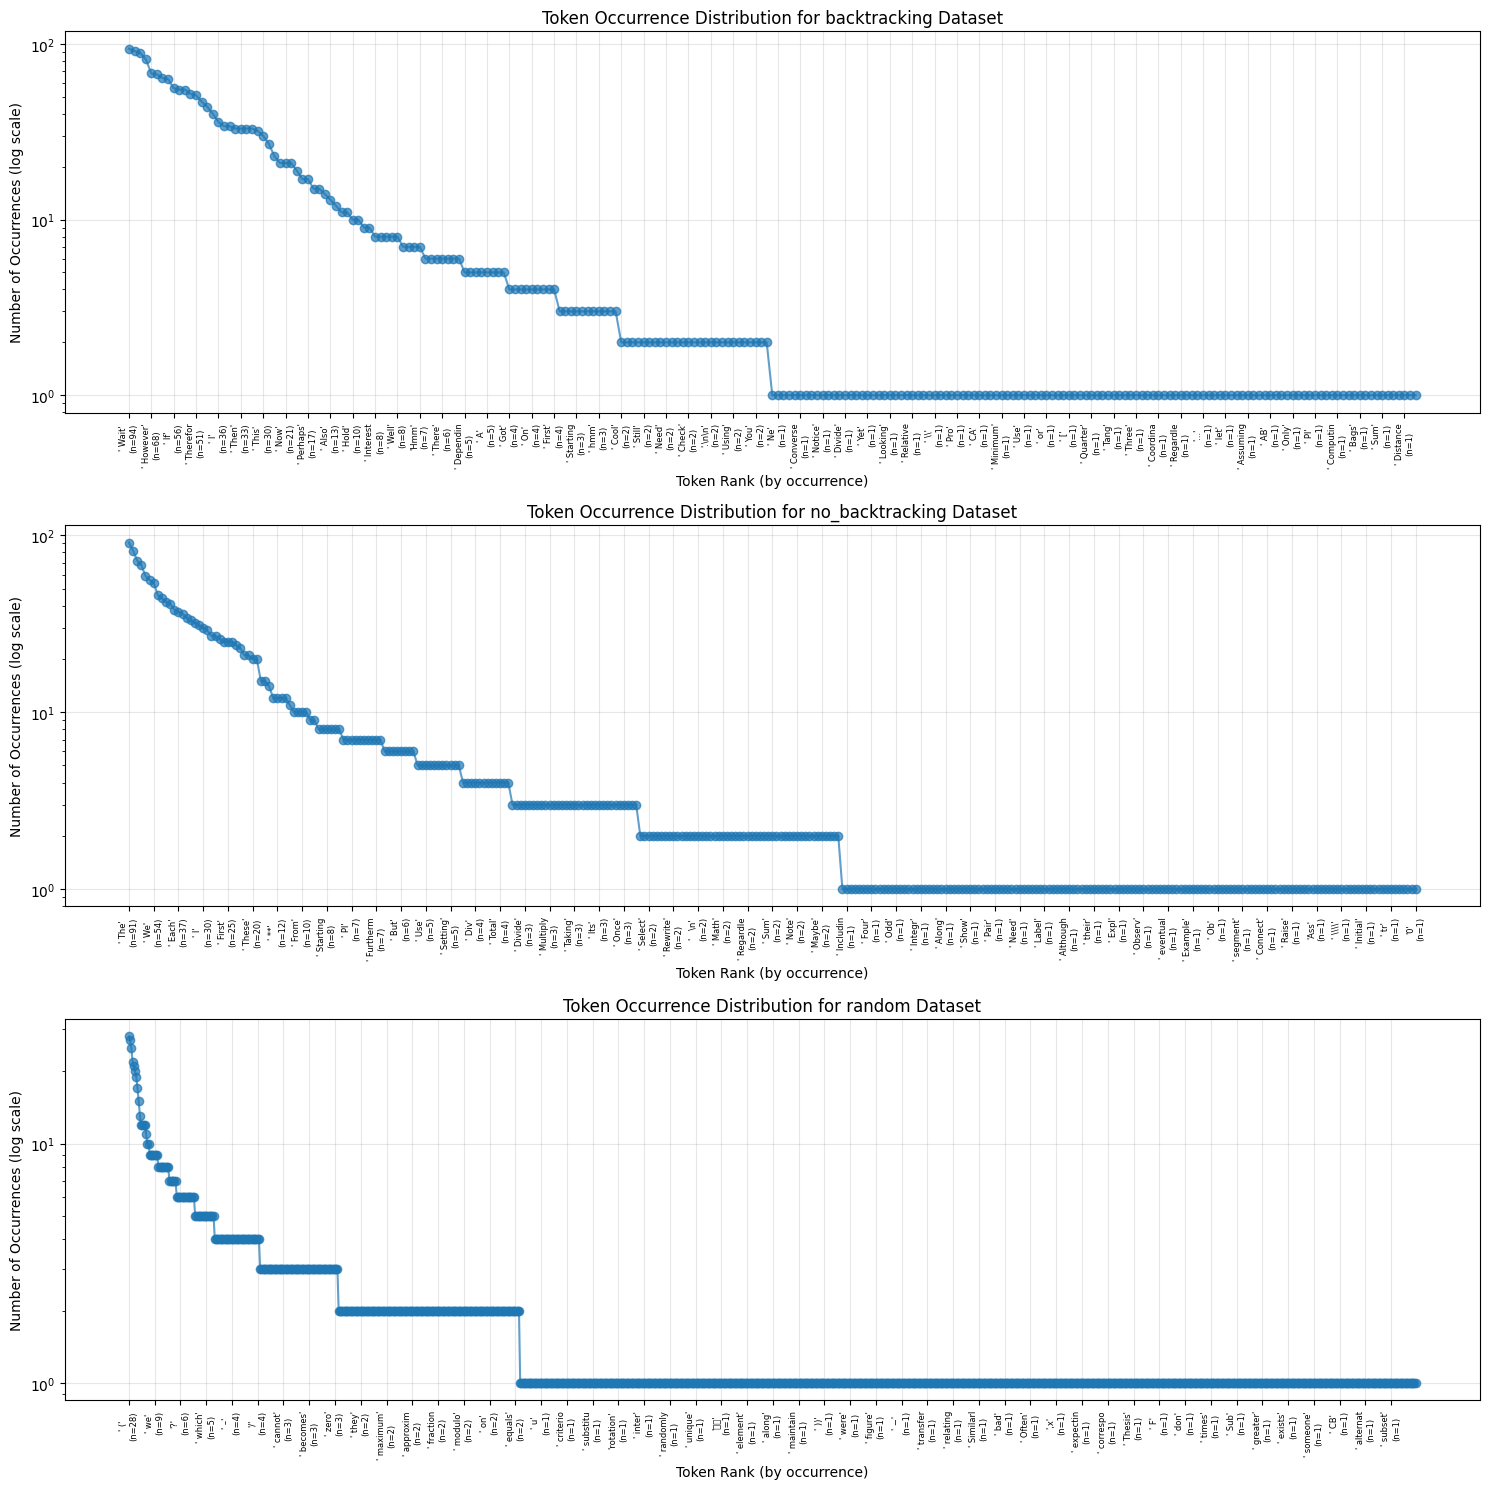

In [10]:
# Create a figure for plotting token occurrence distributions
plt.figure(figsize=(15, 5 * len(results)))
fig, axes = plt.subplots(len(results), 1, figsize=(15, 5 * len(results)))

# If there's only one dataset, make axes iterable
if len(results) == 1:
    axes = [axes]

# Plot occurrence distributions for each dataset
for i, dataset_name in enumerate(results.keys()):
    # Get tokens data for this dataset
    tokens_data = results[dataset_name]
    
    # Sort by count (descending)
    sorted_tokens = sorted(tokens_data, key=lambda x: x[1]["count"], reverse=True)
    
    # Extract token and count information
    tokens = [token for token, _ in sorted_tokens]
    counts = [stats["count"] for _, stats in sorted_tokens]
    token_ids = [stats["token_id"] for _, stats in sorted_tokens]
    
    # Create a DataFrame for easier plotting
    df = pd.DataFrame({
        "token": tokens,
        "count": counts,
        "token_id": token_ids
    })
    
    # Plot the distribution
    axes[i].plot(range(len(df)), df["count"], marker='o', linestyle='-', alpha=0.7)
    axes[i].set_yscale('log')  # Log scale to better visualize the distribution
    
    # Set labels and title
    axes[i].set_xlabel("Token Rank (by occurrence)")
    axes[i].set_ylabel("Number of Occurrences (log scale)")
    axes[i].set_title(f"Token Occurrence Distribution for {dataset_name} Dataset")
    axes[i].grid(True, alpha=0.3)
    
    # Add token labels for all tokens vertically at the bottom
    # Determine how many tokens to label to avoid overcrowding
    max_tokens_to_label = min(50, len(df))  # Limit to 50 tokens or less
    step = max(1, len(df) // max_tokens_to_label)
    
    # Create x-ticks at regular intervals
    tick_positions = list(range(0, len(df), step))
    axes[i].set_xticks(tick_positions)
    
    # Create labels for each tick position
    tick_labels = []
    for idx in tick_positions:
        if idx < len(df):
            token_display = repr(df.iloc[idx]["token"])[:10]
            tick_labels.append(f"{token_display}\n(n={df.iloc[idx]['count']})")
    
    # Set the x-tick labels with vertical orientation and very small font size
    axes[i].set_xticklabels(tick_labels, rotation=90, ha='center', fontsize=6)
    
    # Adjust bottom margin to make room for labels
    plt.subplots_adjust(bottom=0.2)

plt.tight_layout()
plt.show()


In [20]:
# Filter datasets to contain only data points with questions and prefixes under 300 tokens
filtered_datasets = {}

for dataset_key, dataset in datasets.items():
    filtered_data = []
    
    for data_point in dataset:
        question = data_point['question']
        prefix = data_point['prefix']
        
        # Tokenize to check token length
        question_tokens = model.to_tokens(question)
        prefix_tokens = model.to_tokens(prefix)
        
        # Check if both are under 400 tokens
        if len(question_tokens[0]) <= 400 and len(prefix_tokens[0]) <= 400:
            filtered_data.append(data_point)
    
    filtered_datasets[dataset_key] = filtered_data
    print(f"Dataset '{dataset_key}': Original size = {len(dataset)}, Filtered size = {len(filtered_data)}")

# Replace the original datasets with the filtered ones
datasets = filtered_datasets


Dataset 'backtracking': Original size = 1000, Filtered size = 142
Dataset 'no_backtracking': Original size = 1000, Filtered size = 995
Dataset 'random': Original size = 1000, Filtered size = 152


In [37]:
import random
import matplotlib.pyplot as plt
import torch
from einops import einsum

# Select a random prompt from the backtracking dataset
dataset_name = "backtracking"  # Use the dictionary key instead of index
# Set a random seed for reproducibility

random.seed(44)
torch.manual_seed(44)
np.random.seed(44)

random_prompt_idx = random.randint(0, len(datasets[dataset_name]) - 1)
question = datasets[dataset_name][random_prompt_idx]['question']
prefix = datasets[dataset_name][random_prompt_idx]['prefix']

# Format the prompt
prompt = format_prompt(question, prefix)

print(f"Selected prompt: {prompt}")

Selected prompt: <｜begin▁of▁sentence｜>You are a helpful assistant.<｜User｜>How many different four-digit numbers can be formed from the digits 0, 1, 2, 3 if each digit appears only once in the number?<｜Assistant｜><think>
Okay, so I need to figure out how many different four-digit numbers can be formed using the digits 0, 1, 2, 3 without repeating any digits.


In [38]:
# Run the model directly on the prompt
print("Running model on the prompt...")

# Clear GPU memory before running
torch.cuda.empty_cache()

# Get model output for the prompt
with torch.no_grad():
    tokens = model.to_tokens(prompt)
    logits = model(tokens)
    
    # Get the output probabilities
    probs = torch.softmax(logits[:, -1], dim=-1)
    
    # Get the top 5 predicted tokens
    top_k = 5
    topk_probs, topk_indices = torch.topk(probs, top_k)
    
    print("\nTop predicted next tokens:")
    for i in range(top_k):
        token = model.to_string(topk_indices[0, i].item())
        prob = topk_probs[0, i].item()
        print(f"{i+1}. '{token}' (probability: {prob:.4f})")


Running model on the prompt...

Top predicted next tokens:
1. ' Hmm' (probability: 0.9648)
2. ' Let' (probability: 0.0121)
3. ' Alright' (probability: 0.0095)
4. ' Each' (probability: 0.0084)
5. ' H' (probability: 0.0035)


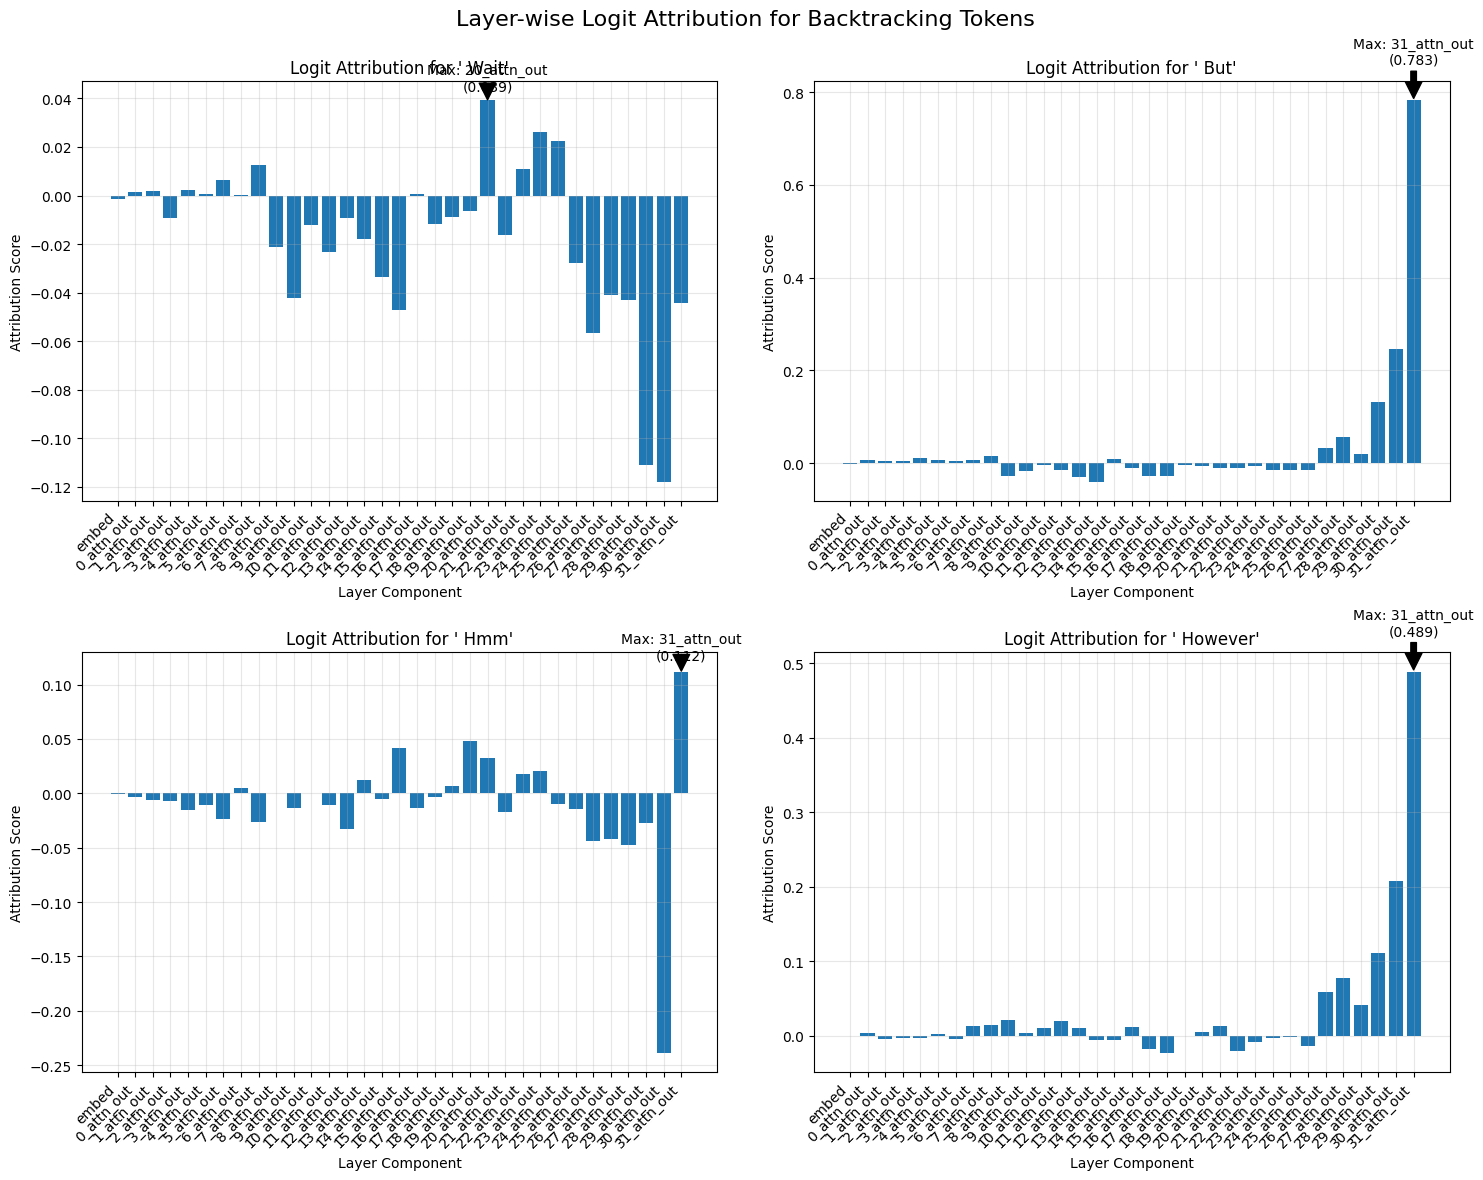

In [ ]:
# %% Direct Logit Attribution for Backtracking Dataset

# Run the model with cache
logits, cache = model.run_with_cache(prompt)

# Tokens to analyze
tokens_to_analyze = [" Wait", " But", " Hmm", " However"]
token_ids = [model.to_single_token(token) for token in tokens_to_analyze]

# Get the decomposed residual stream by attention layers
residual_stream, labels = cache.decompose_resid(return_labels=True, mode="attn")

# Create a figure with 4 subplots (one for each token)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (token, token_id) in enumerate(zip(tokens_to_analyze, token_ids)):
    # Get logit attributions for this token
    logit_attrs = cache.logit_attrs(residual_stream, token_id)
    
    # Average across batch and position dimensions to get per-layer attribution
    # Shape will be [num_components]
    avg_logit_attrs = logit_attrs.mean(dim=tuple(range(1, logit_attrs.dim())))
    
    # Plot the attributions
    # Use detach() before numpy() to avoid the "requires grad" error
    axes[i].bar(range(len(avg_logit_attrs)), avg_logit_attrs.detach().cpu().numpy())
    axes[i].set_title(f"Logit Attribution for '{token}'")
    axes[i].set_xlabel("Layer Component")
    axes[i].set_ylabel("Attribution Score")
    
    # Add layer labels
    axes[i].set_xticks(range(len(labels)))
    axes[i].set_xticklabels(labels, rotation=45, ha='right')
    
    # Highlight the most important layer
    max_idx = torch.argmax(avg_logit_attrs).item()
    max_value = avg_logit_attrs[max_idx].item()
    axes[i].annotate(f"Max: {labels[max_idx]}\n({max_value:.3f})", 
                     xy=(max_idx, max_value),
                     xytext=(max_idx, max_value + 0.1 * max_value),
                     arrowprops=dict(facecolor='black', shrink=0.05),
                     ha='center')
    
    # Add grid for better readability
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("Layer-wise Logit Attribution for Backtracking Tokens", fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()


In [35]:
cache["blocks.20.hook_resid_post"].shape

torch.Size([1, 119, 4096])

In [36]:
# Print the length of the prompt
prompt = format_prompt(datasets[dataset_name][0]['question'], datasets[dataset_name][0]['prefix'])
tokens = model.to_tokens(prompt)
print(f"Prompt length in tokens: {tokens.shape[1]}")


Prompt length in tokens: 96


In [24]:
import gc
# Clear GPU memory to avoid out of memory errors
torch.cuda.empty_cache()
gc.collect()

# Move model to CPU to free up GPU memory
model.to("cuda")

# Print memory stats to verify cleanup
print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"GPU memory reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")


Moving model to device:  cuda
GPU memory allocated: 19.26 GB
GPU memory reserved: 47.25 GB


Moving model to device:  cuda
Processed 0 items out of 142
Processed 10 items out of 142
Processed 20 items out of 142
Processed 30 items out of 142
Processed 40 items out of 142
Processed 50 items out of 142
Processed 60 items out of 142
Processed 70 items out of 142
Processed 80 items out of 142
Processed 90 items out of 142
Processed 100 items out of 142
Processed 110 items out of 142
Processed 120 items out of 142
Processed 130 items out of 142
Processed 140 items out of 142


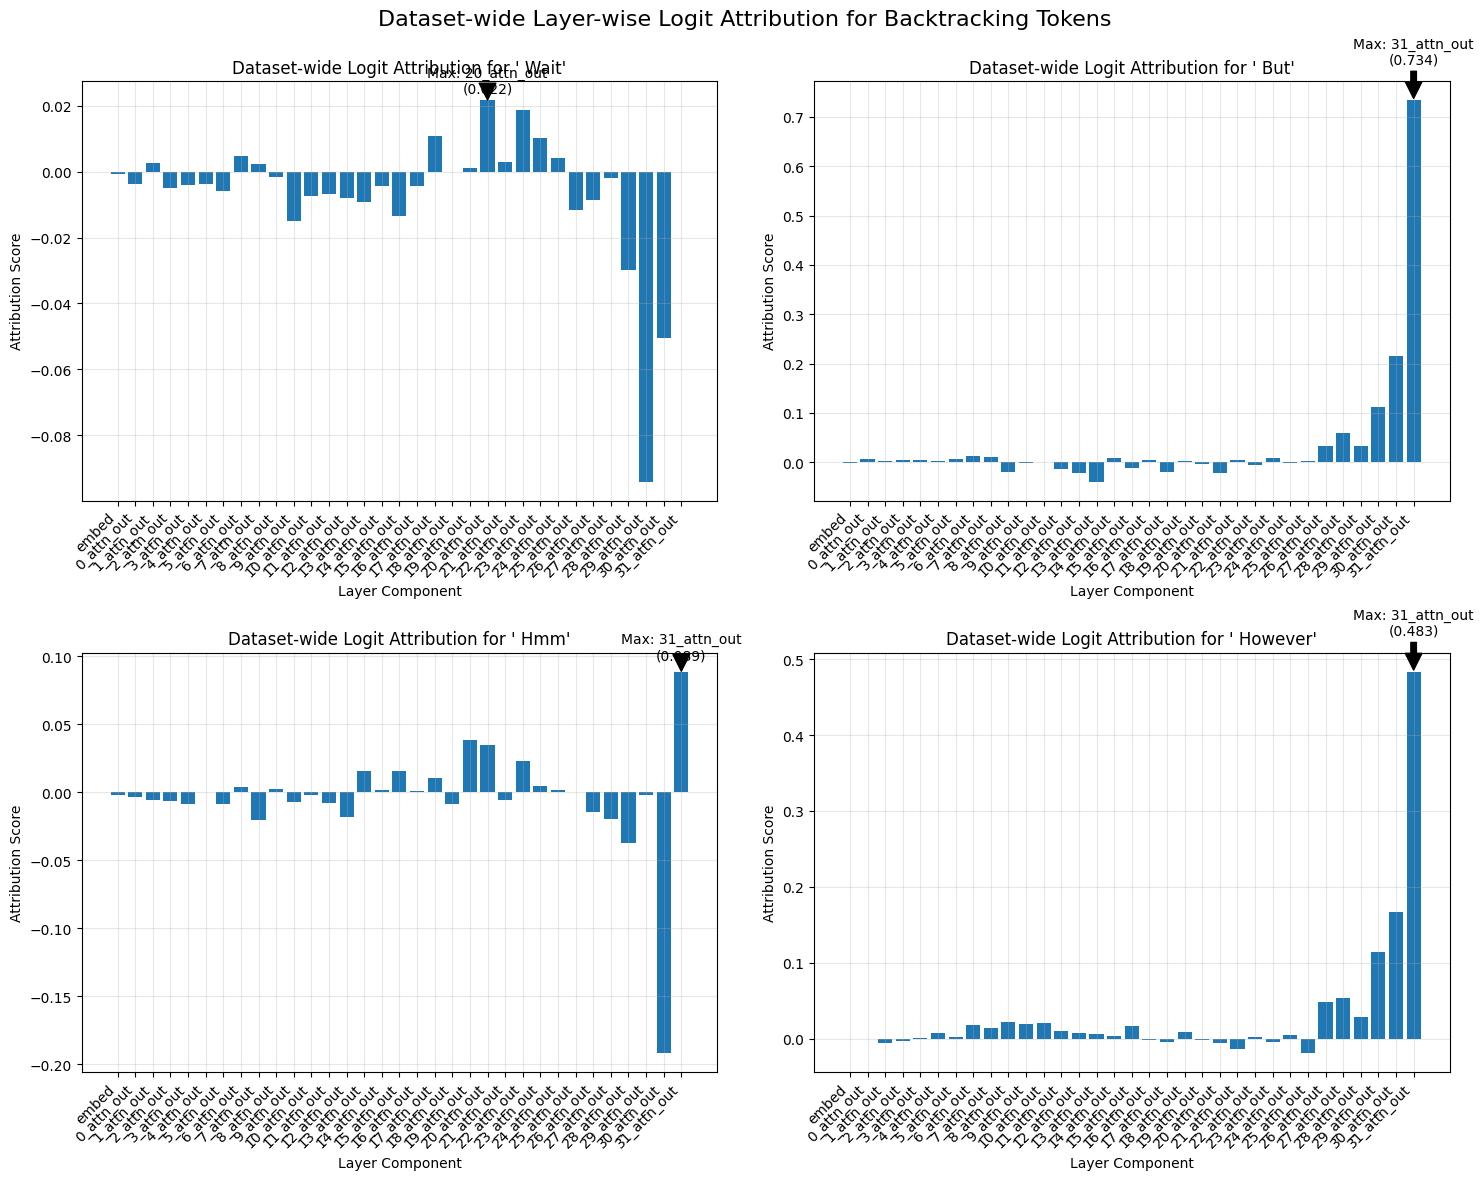

In [26]:
from transformer_lens import ActivationCache
import gc
import torch

token_ids = [model.to_single_token(token) for token in tokens_to_analyze]

# Initialize dictionary to accumulate attributions across all dataset items
accumulated_attributions = {token: torch.zeros(len(model.blocks) * 2, device="cpu") for token in tokens_to_analyze}
dataset_count = 0
labels = None

# Ensure model is on GPU once at the beginning
model.to("cuda")

# Process each item in the dataset individually
for idx in range(len(datasets[dataset_name])):
    # Get question and prefix from the dataset
    question = datasets[dataset_name][idx]['question']
    prefix = datasets[dataset_name][idx]['prefix']
    prompt = format_prompt(question, prefix)
    
    try:
        # Process the entire prompt at once
        tokens = model.to_tokens(prompt).to("cuda")
        
        # Run the model with cache
        with torch.no_grad():
            _, cache = model.run_with_cache(tokens)
        
        # Get the decomposed residual stream by attention layers
        residual_stream, current_labels = cache.decompose_resid(return_labels=True, mode="attn")
        
        # Make sure we're using the same residual_stream shape for all items
        if labels is None:
            labels = current_labels
            # Initialize with the correct size based on the first item
            for token in tokens_to_analyze:
                accumulated_attributions[token] = torch.zeros(len(residual_stream), device="cpu")
        
        # Process each token
        for token, token_id in zip(tokens_to_analyze, token_ids):
            # Get logit attributions for this token
            logit_attrs = cache.logit_attrs(residual_stream, token_id)
            
            # Average across batch and position dimensions
            avg_attrs = logit_attrs.mean(dim=tuple(range(1, logit_attrs.dim())))
            
            # Move to CPU immediately and accumulate
            accumulated_attributions[token] += avg_attrs.detach().cpu()
        
        dataset_count += 1
        
        # Optional: Print progress
        if idx % 10 == 0:
            print(f"Processed {idx} items out of {len(datasets[dataset_name])}")
    
    except Exception as e:
        print(f"Error processing item {idx}: {e}")
    
    # Clear memory after each item
    del tokens, cache, residual_stream
    if 'logit_attrs' in locals():
        del logit_attrs
    
    torch.cuda.empty_cache()
    gc.collect()

# Calculate the average attributions across all processed items
if dataset_count > 0:
    for token in tokens_to_analyze:
        accumulated_attributions[token] /= dataset_count

# Create a figure with 4 subplots (one for each token)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (token, token_id) in enumerate(zip(tokens_to_analyze, token_ids)):
    # Get the average attribution for this token
    avg_logit_attrs = accumulated_attributions[token]
    
    # Plot the attributions
    axes[i].bar(range(len(avg_logit_attrs)), avg_logit_attrs.numpy())
    axes[i].set_title(f"Dataset-wide Logit Attribution for '{token}'")
    axes[i].set_xlabel("Layer Component")
    axes[i].set_ylabel("Attribution Score")
    
    # Add layer labels
    axes[i].set_xticks(range(len(labels)))
    axes[i].set_xticklabels(labels, rotation=45, ha='right')
    
    # Highlight the most important layer
    max_idx = torch.argmax(avg_logit_attrs).item()
    max_value = avg_logit_attrs[max_idx].item()
    axes[i].annotate(f"Max: {labels[max_idx]}\n({max_value:.3f})", 
                     xy=(max_idx, max_value),
                     xytext=(max_idx, max_value + 0.1 * max_value),
                     arrowprops=dict(facecolor='black', shrink=0.05),
                     ha='center')
    
    # Add grid for better readability
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("Dataset-wide Layer-wise Logit Attribution for Backtracking Tokens", fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()


Computing activation differences between backtracking and non-backtracking datasets using TransformerLens...
Processed 142 examples from backtracking dataset
Processed 500 examples from no_backtracking dataset
Activation difference vector for last token has shape: torch.Size([4096])


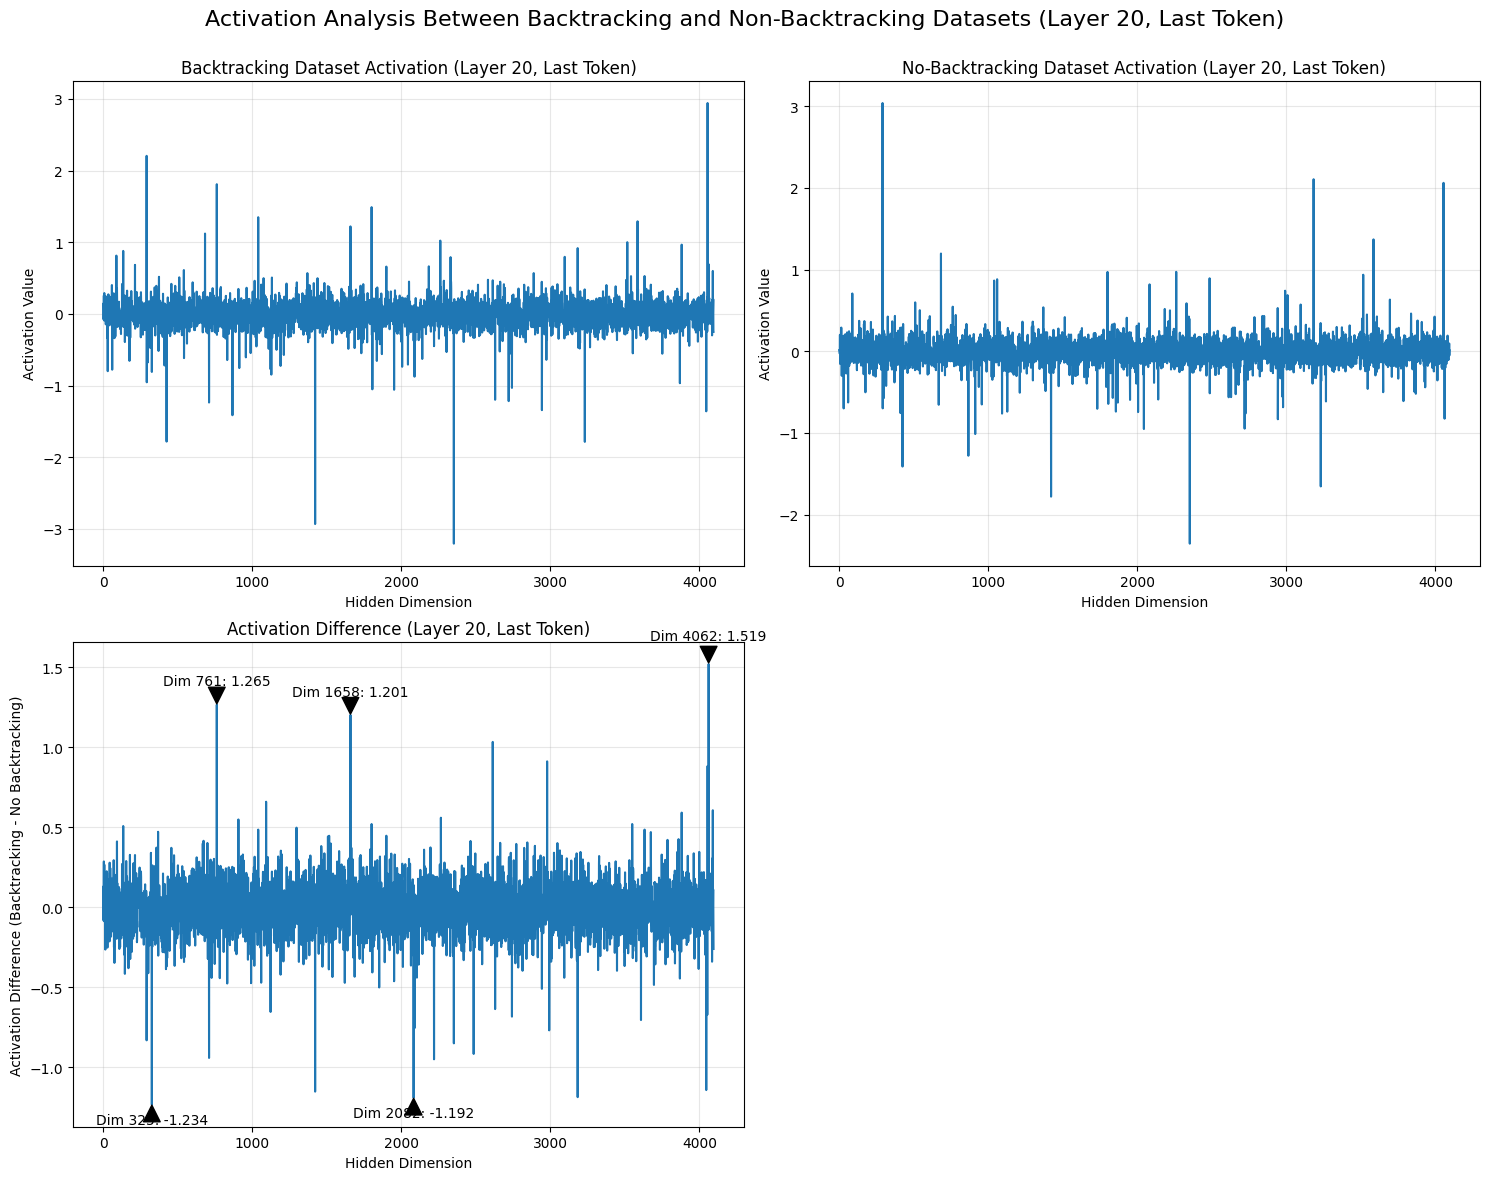

In [31]:
import tqdm

# Get activations for both datasets and compute the difference vector using TransformerLens
print("Computing activation differences between backtracking and non-backtracking datasets using TransformerLens...")

max_examples = 500
# Initialize tensors to store accumulated activations for the last token position
backtracking_activation = torch.zeros(model.cfg.d_model, dtype=torch.float32)
no_backtracking_activation = torch.zeros(model.cfg.d_model, dtype=torch.float32)

# Track counts for averaging
backtracking_count = 0
no_backtracking_count = 0

# Process both datasets
for dataset_name in ["backtracking", "no_backtracking"]:
    # Reset dataset counter
    dataset_count = 0
    
    # Use the datasets from the filtered_datasets dictionary
    dataset = datasets[dataset_name]
    
    # Process each example
    for i, example in enumerate(dataset):
        # Skip if we've processed enough examples
        if i >= max_examples:
            break
            
        # Get the input text (question + prefix)
        input_text = example["question"] + example["prefix"]
        
        # Skip if the input is too long (check before running the model)
        tokens = tokenizer.encode(input_text)
        if len(tokens) > model.cfg.n_ctx:
            print(f"Skipping example {i} because it's too long")
            continue
        
        # Run the model with cache using TransformerLens
        with torch.no_grad():
            _, cache = model.run_with_cache(input_text)
            
        # Get the activations from layer 20 for the last token
        layer_20_activations = cache["blocks.20.hook_resid_post"]  # Get activations from layer 20
        last_token_activation = layer_20_activations[0, -1, :].detach().cpu()  # Get the last token position
        
        # Accumulate activations based on dataset
        if dataset_name == "backtracking":
            backtracking_activation += last_token_activation
        else:
            no_backtracking_activation += last_token_activation
        
        # Increment the dataset counter
        dataset_count += 1
        
        # Free up memory
        del cache
        torch.cuda.empty_cache()
        gc.collect()
    
    # Update the appropriate counter
    if dataset_name == "backtracking":
        backtracking_count = dataset_count
    else:
        no_backtracking_count = dataset_count
    
    print(f"Processed {dataset_count} examples from {dataset_name} dataset")

# Calculate average activations
if backtracking_count > 0:
    backtracking_activation /= backtracking_count
if no_backtracking_count > 0:
    no_backtracking_activation /= no_backtracking_count

# Compute the difference vector
activation_difference = backtracking_activation - no_backtracking_activation
print(f"Activation difference vector for last token has shape: {activation_difference.shape}")

# Visualize the activation differences
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Plot the backtracking activation
axes[0].plot(range(len(backtracking_activation)), backtracking_activation.numpy())
axes[0].set_title(f"Backtracking Dataset Activation (Layer 20, Last Token)")
axes[0].set_xlabel("Hidden Dimension")
axes[0].set_ylabel("Activation Value")
axes[0].grid(True, alpha=0.3)

# Plot the no-backtracking activation
axes[1].plot(range(len(no_backtracking_activation)), no_backtracking_activation.numpy())
axes[1].set_title(f"No-Backtracking Dataset Activation (Layer 20, Last Token)")
axes[1].set_xlabel("Hidden Dimension")
axes[1].set_ylabel("Activation Value")
axes[1].grid(True, alpha=0.3)

# Plot the activation difference
axes[2].plot(range(len(activation_difference)), activation_difference.numpy())
axes[2].set_title(f"Activation Difference (Layer 20, Last Token)")
axes[2].set_xlabel("Hidden Dimension")
axes[2].set_ylabel("Activation Difference (Backtracking - No Backtracking)")
axes[2].grid(True, alpha=0.3)

# Highlight the dimensions with the largest absolute differences
top_k = 5
abs_diff = torch.abs(activation_difference)
top_indices = torch.topk(abs_diff, top_k).indices

for idx in top_indices:
    value = activation_difference[idx].item()
    axes[2].annotate(f"Dim {idx}: {value:.3f}", 
                     xy=(idx, value),
                     xytext=(idx, value + (0.1 * abs(value)) * (1 if value >= 0 else -1)),
                     arrowprops=dict(facecolor='black', shrink=0.05),
                     ha='center')

# Leave the fourth subplot empty or use it for additional analysis
axes[3].set_visible(False)

plt.tight_layout()
plt.suptitle("Activation Analysis Between Backtracking and Non-Backtracking Datasets (Layer 20, Last Token)", fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()


Difference vector shape: torch.Size([4096])
Difference vector norm: 10.427563667297363


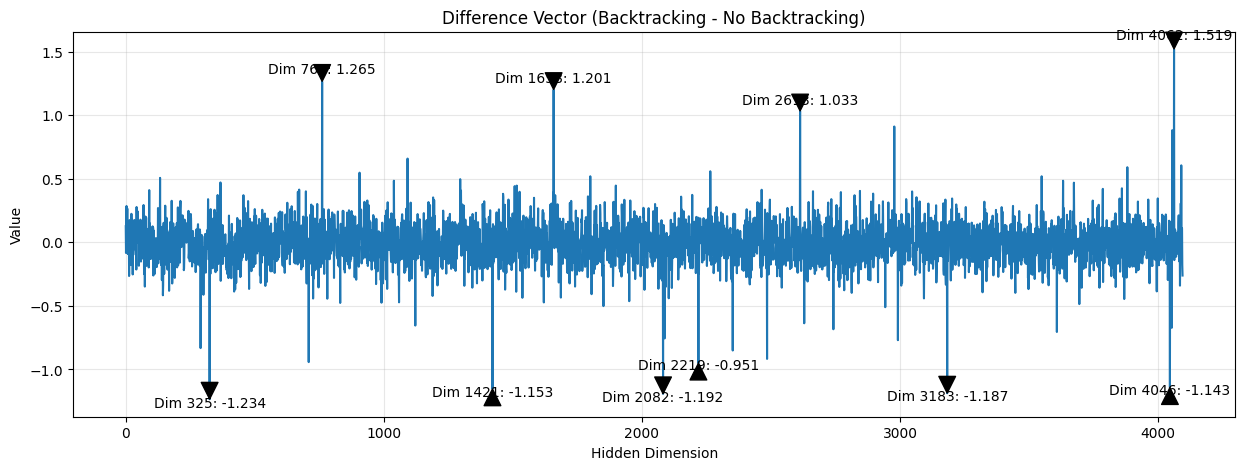

In [39]:
# Compute the difference vector between backtracking and no-backtracking activations
difference_vector = backtracking_activation - no_backtracking_activation

print(f"Difference vector shape: {difference_vector.shape}")
print(f"Difference vector norm: {torch.norm(difference_vector)}")

# Visualize the difference vector
plt.figure(figsize=(15, 5))
plt.plot(range(len(difference_vector)), difference_vector.numpy())
plt.title("Difference Vector (Backtracking - No Backtracking)")
plt.xlabel("Hidden Dimension")
plt.ylabel("Value")
plt.grid(True, alpha=0.3)

# Highlight the dimensions with the largest absolute values
top_k = 10
abs_values = torch.abs(difference_vector)
top_indices = torch.topk(abs_values, top_k).indices

for idx in top_indices:
    value = difference_vector[idx].item()
    plt.annotate(f"Dim {idx}: {value:.3f}", 
                xy=(idx, value),
                xytext=(idx, value + (0.05 * abs(value)) * (1 if value >= 0 else -1)),
                arrowprops=dict(facecolor='black', shrink=0.05),
                ha='center')

plt.show()



In [40]:
prompt

'<｜begin▁of▁sentence｜>You are a helpful assistant.<｜User｜>How many different four-digit numbers can be formed from the digits 0, 1, 2, 3 if each digit appears only once in the number?<｜Assistant｜><think>\nOkay, so I need to figure out how many different four-digit numbers can be formed using the digits 0, 1, 2, 3 without repeating any digits.'

In [43]:
from transformer_lens import utils
# Run the model on a random backtracking prompt, but patch the activation so that the difference vector is subtracted inside layer 20

# First, let's create a random backtracking prompt
backtracking_prompt = prompt

# Tokenize the prompt
backtracking_tokens = model.to_tokens(backtracking_prompt)

# Make sure the difference vector is on the same device as the model
difference_vector = difference_vector.to(device)

# Define a hook function to patch the activation at layer 20
def patch_activation_hook(activation, hook):
    # Only modify the last token's activation
    activation[:, -1, :] = activation[:, -1, :] - difference_vector
    return activation

# Run the model with the patching hook
patched_logits = model.run_with_hooks(
    backtracking_tokens,
    fwd_hooks=[
        (utils.get_act_name("resid_post", 20), patch_activation_hook)
    ]
)

# Get the original logits without patching for comparison
original_logits = model(backtracking_tokens)

# Print the top logits for the last token
def print_top_logits(logits, prefix=""):
    # Get the logits for the last token
    last_token_logits = logits[0, -1, :]
    
    # Get the top 10 tokens
    top_values, top_indices = torch.topk(last_token_logits, 10)
    
    print(f"{prefix} Top 10 tokens:")
    for i, (value, idx) in enumerate(zip(top_values, top_indices)):
        token_str = model.to_string(idx)
        print(f"{i+1}. {token_str!r:<20} {value.item():.3f}")

print("\nOriginal prediction (with backtracking):")
print_top_logits(original_logits, "Original")

print("\nPatched prediction (backtracking - difference vector):")
print_top_logits(patched_logits, "Patched")

# Calculate the difference in probabilities
original_probs = torch.nn.functional.softmax(original_logits[0, -1, :], dim=-1)
patched_probs = torch.nn.functional.softmax(patched_logits[0, -1, :], dim=-1)

# Get the top 5 tokens with the biggest probability changes
prob_diff = patched_probs - original_probs
top_diff_values, top_diff_indices = torch.topk(prob_diff, 5)
bottom_diff_values, bottom_diff_indices = torch.topk(prob_diff, 5, largest=False)

print("\nTokens with largest probability increases after patching:")
for i, (value, idx) in enumerate(zip(top_diff_values, top_diff_indices)):
    token_str = model.to_string(idx)
    orig_prob = original_probs[idx].item() * 100
    patched_prob = patched_probs[idx].item() * 100
    print(f"{i+1}. {token_str!r:<20} +{value.item()*100:.3f}% ({orig_prob:.3f}% → {patched_prob:.3f}%)")

print("\nTokens with largest probability decreases after patching:")
for i, (value, idx) in enumerate(zip(bottom_diff_values, bottom_diff_indices)):
    token_str = model.to_string(idx)
    orig_prob = original_probs[idx].item() * 100
    patched_prob = patched_probs[idx].item() * 100
    print(f"{i+1}. {token_str!r:<20} {value.item()*100:.3f}% ({orig_prob:.3f}% → {patched_prob:.3f}%)")



Original prediction (with backtracking):
Original Top 10 tokens:
1. ' Hmm'               24.500
2. ' Let'               20.125
3. ' Alright'           19.875
4. ' Each'              19.750
5. ' H'                 18.875
6. ' That'              16.375
7. ' All'               15.750
8. ' Since'             15.562
9. 'Hmm'                15.000
10. ' Wait'              14.875

Patched prediction (backtracking - difference vector):
Patched Top 10 tokens:
1. ' Each'              22.625
2. ' Hmm'               20.625
3. ' Let'               20.500
4. ' Since'             18.500
5. ' This'              17.875
6. ' First'             17.625
7. ' The'               17.500
8. ' Alright'           17.500
9. ' I'                 17.125
10. ' That'              17.125

Tokens with largest probability increases after patching:
1. ' Each'              +75.391% (0.836% → 76.172%)
2. ' Let'               +7.910% (1.215% → 9.131%)
3. ' Since'             +1.221% (0.013% → 1.233%)
4. ' This'            

In [45]:
# Let's try scaling the difference vector by different values and see how it affects the results
alphas = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]  # Different scaling factors to try

for alpha in alphas:
    print(f"\n\n{'='*50}")
    print(f"Testing with scaling factor alpha = {alpha}")
    print(f"{'='*50}")
    
    # Define a hook function to patch the activation with scaled difference vector
    def patch_activation_hook_scaled(activation, hook):
        # Only modify the last token's activation
        activation[:, -1, :] = activation[:, -1, :] - alpha * difference_vector
        return activation
    
    # Run the model with the scaled patching hook
    patched_logits_scaled = model.run_with_hooks(
        backtracking_tokens,
        fwd_hooks=[
            (utils.get_act_name("resid_post", 20), patch_activation_hook_scaled)
        ]
    )
    
    # Print the top logits for the scaled patching
    print(f"\nPatched prediction (backtracking - {alpha} * difference vector):")
    print_top_logits(patched_logits_scaled, f"Alpha={alpha}")
    
    # Calculate the difference in probabilities
    patched_probs_scaled = torch.nn.functional.softmax(patched_logits_scaled[0, -1, :], dim=-1)
    
    # Get the top 5 tokens with the biggest probability changes
    prob_diff_scaled = patched_probs_scaled - original_probs
    top_diff_values_scaled, top_diff_indices_scaled = torch.topk(prob_diff_scaled, 5)
    bottom_diff_values_scaled, bottom_diff_indices_scaled = torch.topk(prob_diff_scaled, 5, largest=False)
    
    print(f"\nTokens with largest probability increases after patching (alpha={alpha}):")
    for i, (value, idx) in enumerate(zip(top_diff_values_scaled, top_diff_indices_scaled)):
        token_str = model.to_string(idx)
        orig_prob = original_probs[idx].item() * 100
        patched_prob = patched_probs_scaled[idx].item() * 100
        print(f"{i+1}. {token_str!r:<20} +{value.item()*100:.3f}% ({orig_prob:.3f}% → {patched_prob:.3f}%)")
    
    print(f"\nTokens with largest probability decreases after patching (alpha={alpha}):")
    for i, (value, idx) in enumerate(zip(bottom_diff_values_scaled, bottom_diff_indices_scaled)):
        token_str = model.to_string(idx)
        orig_prob = original_probs[idx].item() * 100
        patched_prob = patched_probs_scaled[idx].item() * 100
        print(f"{i+1}. {token_str!r:<20} {value.item()*100:.3f}% ({orig_prob:.3f}% → {patched_prob:.3f}%)")




Testing with scaling factor alpha = 0.4

Patched prediction (backtracking - 0.4 * difference vector):
Alpha=0.4 Top 10 tokens:
1. ' Hmm'               23.750
2. ' Each'              21.000
3. ' Let'               20.250
4. ' Alright'           19.750
5. ' H'                 18.000
6. ' That'              17.125
7. ' Since'             17.000
8. ' All'               16.250
9. ' I'                 15.750
10. ' The'               15.062

Tokens with largest probability increases after patching (alpha=0.4):
1. ' Each'              +4.883% (0.836% → 5.713%)
2. ' Let'               +1.483% (1.215% → 2.698%)
3. ' Alright'           +0.690% (0.946% → 1.636%)
4. ' Since'             +0.092% (0.013% → 0.105%)
5. ' That'              +0.090% (0.029% → 0.118%)

Tokens with largest probability decreases after patching (alpha=0.4):
1. ' Hmm'               -7.031% (96.484% → 89.453%)
2. ' H'                 -0.064% (0.348% → 0.284%)
3. ' Wait'              -0.003% (0.006% → 0.003%)
4. 'Hmm'        

In [ ]:
backtracking_prompt

In [55]:
# Now let's run a full generation with the patched model using alpha=1.0
print("\n\n" + "="*50)
print("Full generation with patched model (alpha=1.0)")
print("="*50)

# Define the patching hook with alpha=1.0
def patch_activation_hook_generation(activation, hook):
    # Only modify the last token's activation in each forward pass
    activation[:, -1, :] = activation[:, -1, :] - 1.0 * difference_vector
    return activation

# Set up the generation parameters
max_new_tokens = 8192
temperature = 0.8
top_p = 0.9
do_sample = True

# Create a context manager to apply hooks during generation
with model.hooks(fwd_hooks=[(utils.get_act_name("resid_post", 20), patch_activation_hook_generation)]):
    # Run the model with the patching hook for the entire generation
    patched_tokens = model.generate(
        backtracking_tokens, 
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_p=top_p,
        do_sample=do_sample,
        verbose=True
    )

# Print the full generated text
print("\nFull patched generation:")
print(model.to_string(patched_tokens))

# For comparison, let's also run an unpatched generation
print("\n\n" + "="*50)
print("Unpatched generation (for comparison)")
print("="*50)

unpatched_tokens = model.generate(
    backtracking_tokens,
    max_new_tokens=max_new_tokens,
    temperature=temperature,
    top_p=top_p,
    do_sample=do_sample,
    verbose=True
)

print("\nFull unpatched generation:")
print(model.to_string(unpatched_tokens))




Full generation with patched model (alpha=1.0)


  0%|          | 0/8192 [00:00<?, ?it/s]


Full patched generation:
["<｜begin▁of▁sentence｜><｜begin▁of▁sentence｜>You are a helpful assistant.<｜User｜>How many different four-digit numbers can be formed from the digits 0, 1, 2, 3 if each digit appears only once in the number?<｜Assistant｜><think>\nOkay, so I need to figure out how many different four-digit numbers can be formed using the digits 0, 1, 2, 3 without repeating any digits. Each digit must appear only once in the number. \n\nFirst, let's consider what a four-digit number requires. A four-digit number has four places: thousands, hundreds, tens, and units. The thousands place cannot be zero because then the number would be a three-digit number. Therefore, the thousands place must be one of the non-zero digits: 1, 2, or 3. \n\nWe have three choices for the thousands place. After selecting the thousands digit, we have three remaining digits to place in the hundreds, tens, and units places. These digits include the three remaining digits from the original set (including 0), 

  0%|          | 0/8192 [00:00<?, ?it/s]


Full unpatched generation:
["<｜begin▁of▁sentence｜><｜begin▁of▁sentence｜>You are a helpful assistant.<｜User｜>How many different four-digit numbers can be formed from the digits 0, 1, 2, 3 if each digit appears only once in the number?<｜Assistant｜><think>\nOkay, so I need to figure out how many different four-digit numbers can be formed using the digits 0, 1, 2, 3 without repeating any digits. Hmm, let me think about this step by step. \n\nFirst, a four-digit number means it has to be between 1000 and 9999, right? So the first digit can't be zero because that would make it a three-digit number. That gives me a starting point. \n\nSo, I have the digits 0, 1, 2, 3. I need to arrange these four digits in different ways, but each digit can only be used once. Since it's a four-digit number, I have four positions to fill: thousands, hundreds, tens, and ones place.\n\nLet me break it down by each position.\n\n1. **First digit (thousands place):** Since it can't be zero, I can choose from 1, 2, 

In [67]:
# Create a dataset to store the results
from datasets import Dataset
import tqdm
import os

# Initialize lists to store results
patched_outputs = []
unpatched_outputs = []
questions = []

max_new_tokens = 8192
temperature = 0.7
top_p = 0.9

do_sample = True
# Process each prompt in the dataset, but limit to 30 examples
for item in tqdm.tqdm(filtered_datasets["backtracking"][:50]):
    question = item["question"]
    questions.append(question)
    
    # Format the prompt
    prompt = format_prompt(question, "")
    prompt_tokens = model.to_tokens(prompt)
    
    # Generate with patching
    with model.hooks(fwd_hooks=[(utils.get_act_name("resid_post", 20), patch_activation_hook_generation)]):
        patched_result = model.generate(
            prompt_tokens,
            max_new_tokens=2048,
            temperature=temperature,
            top_p=top_p,
            do_sample=do_sample,
            use_past_kv_cache=True,
        )
        patched_text = model.to_string(patched_result)
        patched_outputs.append(patched_text)
    
    # Generate without patching
    unpatched_result = model.generate(
        prompt_tokens,
        max_new_tokens=2048,
        temperature=temperature,
        top_p=top_p,
        do_sample=do_sample,
        use_past_kv_cache=True,
    )
    unpatched_text = model.to_string(unpatched_result)
    unpatched_outputs.append(unpatched_text)

# Create the dataset
result_dataset = Dataset.from_dict({
    "question": questions,
    "patched_output": patched_outputs,
    "unpatched_output": unpatched_outputs
})

# Push to the Hub
result_dataset.push_to_hub("avrecum/r1_llama3_8b_activation_patched_outputs", private=True, token="")

print(f"Dataset created with {len(result_dataset)} examples and pushed to avrecum/activation_patched_outputs")


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  3%|▎         | 1/30 [00:54<26:26, 54.69s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  7%|▋         | 2/30 [01:49<25:29, 54.63s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 10%|█         | 3/30 [02:29<21:32, 47.87s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 13%|█▎        | 4/30 [03:23<21:53, 50.53s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [04:18<21:40, 52.01s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 20%|██        | 6/30 [05:13<21:09, 52.92s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 23%|██▎       | 7/30 [06:07<20:30, 53.51s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 27%|██▋       | 8/30 [07:02<19:45, 53.90s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 30%|███       | 9/30 [07:57<18:57, 54.16s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 33%|███▎      | 10/30 [08:51<18:05, 54.29s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 37%|███▋      | 11/30 [09:46<17:13, 54.40s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 40%|████      | 12/30 [10:41<16:20, 54.49s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 43%|████▎     | 13/30 [11:35<15:27, 54.55s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 47%|████▋     | 14/30 [12:30<14:33, 54.59s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 50%|█████     | 15/30 [13:25<13:38, 54.57s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 53%|█████▎    | 16/30 [14:19<12:43, 54.54s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 57%|█████▋    | 17/30 [15:14<11:48, 54.52s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 60%|██████    | 18/30 [16:08<10:54, 54.57s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 63%|██████▎   | 19/30 [17:03<10:00, 54.62s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 67%|██████▋   | 20/30 [17:57<09:03, 54.38s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 70%|███████   | 21/30 [18:51<08:10, 54.46s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 73%|███████▎  | 22/30 [19:46<07:16, 54.54s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 77%|███████▋  | 23/30 [20:41<06:22, 54.58s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 80%|████████  | 24/30 [21:35<05:27, 54.61s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 83%|████████▎ | 25/30 [22:30<04:33, 54.68s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 87%|████████▋ | 26/30 [23:25<03:38, 54.70s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 90%|█████████ | 27/30 [24:20<02:44, 54.68s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 93%|█████████▎| 28/30 [25:14<01:49, 54.69s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

 97%|█████████▋| 29/30 [26:09<00:54, 54.68s/it]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

100%|██████████| 30/30 [27:04<00:00, 54.14s/it]


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/367 [00:00<?, ?B/s]

Dataset created with 30 examples and pushed to avrecum/activation_patched_outputs


In [73]:
result_dataset[0]

{'question': 'Given a positive real number \\( x \\), define the sequence \\( \\{a_{n}\\} \\) as \\( a_{n} = \\frac{\\mathrm{e}^{2nx} - 1}{\\mathrm{e}^{2nx} + 1} \\). Prove that for any positive integer \\( n \\), the following inequality holds:\n$$\na_{1} a_{2} \\cdots a_{n} > 1 - \\frac{2}{\\mathrm{e}^{2x}} .\n$$',
 'patched_output': ["<｜begin▁of▁sentence｜><｜begin▁of▁sentence｜>You are a helpful assistant.<｜User｜>Given a positive real number \\( x \\), define the sequence \\( \\{a_{n}\\} \\) as \\( a_{n} = \\frac{\\mathrm{e}^{2nx} - 1}{\\mathrm{e}^{2nx} + 1} \\). Prove that for any positive integer \\( n \\), the following inequality holds:\n$$\na_{1} a_{2} \\cdots a_{n} > 1 - \\frac{2}{\\mathrm{e}^{2x}} .\n$$<｜Assistant｜><think>\nOkay, so I have this problem where I need to prove that for any positive integer \\( n \\), the product \\( a_{1} a_{2} \\cdots a_{n} > 1 - \\frac{2}{\\mathrm{e}^{2x}} \\) holds, where each \\( a_{k} = \\frac{\\mathrm{e}^{2k x} - 1}{\\mathrm{e}^{2k x} + 1} \

In [76]:
import re

def count_words(text, words_to_count):
    """Count occurrences of specific words in text."""
    # Check if text is a list and convert to string if needed
    if isinstance(text, list):
        text = ' '.join(str(item) for item in text)
    
    # Convert text to lowercase for case-insensitive matching
    text_lower = text.lower()
    
    counts = {}
    for word in words_to_count:
        # Use word boundary to match whole words only
        pattern = r'\b' + re.escape(word.lower()) + r'\b'
        count = len(re.findall(pattern, text_lower))
        counts[word] = count
    
    return counts

# Words to count
target_words = ["wait", "but", "however", "hmm", "instead"]

# Count occurrences in both patched and unpatched outputs
patched_word_counts = []
unpatched_word_counts = []

# Print a sample to debug
print(f"Type of patched_output: {type(result_dataset['patched_output'])}")
print(f"Type of first item: {type(result_dataset['patched_output'][0])}")

for patched, unpatched in zip(result_dataset["patched_output"], result_dataset["unpatched_output"]):
    patched_counts = count_words(patched, target_words)
    unpatched_counts = count_words(unpatched, target_words)
    
    patched_word_counts.append(patched_counts)
    unpatched_word_counts.append(unpatched_counts)

# Create a new dataset with the word counts
word_counts_dataset = Dataset.from_dict({
    "question": result_dataset["question"],
    "patched_output": result_dataset["patched_output"],
    "unpatched_output": result_dataset["unpatched_output"],
    "patched_word_counts": patched_word_counts,
    "unpatched_word_counts": unpatched_word_counts
})

# Calculate totals across all examples
patched_totals = {word: sum(counts[word] for counts in patched_word_counts) for word in target_words}
unpatched_totals = {word: sum(counts[word] for counts in unpatched_word_counts) for word in target_words}

print("Total word counts in patched outputs:")
for word, count in patched_totals.items():
    print(f"  {word}: {count}")

print("\nTotal word counts in unpatched outputs:")
for word, count in unpatched_totals.items():
    print(f"  {word}: {count}")

# Calculate differences
print("\nDifference (patched - unpatched):")
for word in target_words:
    diff = patched_totals[word] - unpatched_totals[word]
    print(f"  {word}: {diff:+d}")



Type of patched_output: <class 'list'>
Type of first item: <class 'list'>
Total word counts in patched outputs:
  wait: 0
  but: 2
  however: 3
  hmm: 1
  instead: 1

Total word counts in unpatched outputs:
  wait: 42
  but: 59
  however: 1
  hmm: 43
  instead: 0

Difference (patched - unpatched):
  wait: -42
  but: -57
  however: +2
  hmm: -42
  instead: +1


In [ ]:
dataset

In [74]:
# Calculate the average number of tokens in patched and unpatched outputs count tokens
patched_token_counts = []
unpatched_token_counts = []

for patched, unpatched in zip(result_dataset["patched_output"], result_dataset["unpatched_output"]):
    # For patched outputs (which are lists), join them if needed
    if isinstance(patched, list):
        patched = "".join(patched)
    
    # For unpatched outputs (which are lists), join them if needed
    if isinstance(unpatched, list):
        unpatched = "".join(unpatched)
    
    patched_tokens = tokenizer.encode(patched)
    unpatched_tokens = tokenizer.encode(unpatched)
    
    patched_token_counts.append(len(patched_tokens))
    unpatched_token_counts.append(len(unpatched_tokens))

avg_patched_tokens = sum(patched_token_counts) / len(patched_token_counts)
avg_unpatched_tokens = sum(unpatched_token_counts) / len(unpatched_token_counts)

print("\nAverage output token counts:")
print(f"  Patched outputs: {avg_patched_tokens:.2f} tokens")
print(f"  Unpatched outputs: {avg_unpatched_tokens:.2f} tokens")
print(f"  Difference (patched - unpatched): {avg_patched_tokens - avg_unpatched_tokens:.2f} tokens")




Average output token counts:
  Patched outputs: 574.83 tokens
  Unpatched outputs: 583.53 tokens
  Difference (patched - unpatched): -8.70 tokens
